# Self-attention:

In this notebook, we will explore Self-attention, which can enhance feature representation by weighting different spatial regions of an image based on their relevance. Specifically, we integrate a trainable self-attention module into a ResNet architecture, modifying its feature extraction process.

We apply this self-attention module to the last convolutional block of the ResNet model, allowing it to refine high-level feature maps by selectively emphasizing important regions. For a deeper understanding of the attention mechanism, you can refer to the original paper through [this link](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

In [2]:
import os
import re
from glob import glob
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from imgaug import augmenters as iaa
import cv2
from tqdm import tqdm
from torch.utils.data.sampler import Sampler
from torch.nn import functional as F
from torch.nn.modules import Module
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from torchvision import transforms
import sys
import argparse
import logging
import random
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Subset,SubsetRandomSampler, TensorDataset
from functools import partial
import torchvision.models as models
from PIL import Image
import gc
from pathlib import Path

In [3]:
# loadding a pretrained model's checkpoints
def load_checkpoint(model, optimizer,file_path):
    checkpoint = torch.load(file_path, map_location="cuda:0")

    checkpoint_state_dict = checkpoint['model_state_dict']


    # Create a new state_dict with only the matching keys
    checkpoint_state_dict = {k.replace('module.', ''): v for k, v in checkpoint_state_dict.items()}

    filtered_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model.state_dict()}# and "mlp.mlp_layers.dense_1" not in k and "mlp.mlp_layers.dense_0" not in k and "num_norm" not in k}

    model.load_state_dict(filtered_state_dict, strict=False)

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model

In [4]:
# Initializing  hyperparameters

lr = 1e-3
weight_decay = 1e-3



## Data:

In this project, we use the "NIH" dataset, which is publicly accessible at [this link](https://www.kaggle.com/datasets/nih-chest-xrays/data). It contains 112120 chest X-rays corresponding to 14 different conditions, e.g., Pneumonia, along with the Normal class. The goal of this project is to develop a deep learning model capable of automatically classifying chest X-ray images into one or more of these conditions. Since each image may have multiple labels, we frame this as a multi-label classification problem consisting of 15 binary classification tasks (14 disease categories + 1 Normal class). This means the model must independently predict the presence or absence of each condition for a given image.

In [5]:
def read_image(image_path):
    image = cv2.imread(image_path)
    image = image/np.max(image)
    return image

class XrayDataset(Dataset):
    def __init__(self, csv_file, image_path_name):

        self.path_name = image_path_name
        self.csv_file = csv_file
        self.the_chosen, self.all_classes, self.all_classes_dict = self.choose_the_indices()
        self.csv_file["numeric_targets"] = self.csv_file['Finding Labels'].apply(lambda x: self.get_tagets(x))
    def __len__(self):

        return len(self.csv_file)
    def choose_the_indices(self):

        max_examples_per_class = 10000 # its the maximum number of examples that would be sampled in the training set for any class
        the_chosen = []
        all_classes = {}
        length = len(self.csv_file)
        print('\nSampling the huuuge training dataset')
        for i in tqdm(list(np.random.choice(range(length),length, replace = False))):

            temp = str.split(self.csv_file.iloc[i, :]['Finding Labels'], '|')

            # special case of ultra minority hernia. we will use all the images with 'Hernia' tagged in them.
            if 'Hernia' in temp:
                the_chosen.append(i)
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        all_classes[t] += 1
                continue

            # choose if multiple labels
            if len(temp) > 1:
                bool_lis = [False]*len(temp)
                # check if any label crosses the upper limit
                for idx, t in enumerate(temp):
                    if t in all_classes:
                        if all_classes[t]< max_examples_per_class: # 500
                            bool_lis[idx] = True
                    else:
                        bool_lis[idx] = True
                # if all lables under upper limit, append
                if sum(bool_lis) == len(temp):
                    the_chosen.append(i)
                    # maintain count
                    for t in temp:
                        if t not in all_classes:
                            all_classes[t] = 1
                        else:
                            all_classes[t] += 1
            else:        # these are single label images
                for t in temp:
                    if t not in all_classes:
                        all_classes[t] = 1
                    else:
                        if all_classes[t] < max_examples_per_class: # 500
                            all_classes[t] += 1
                            the_chosen.append(i)


        with open('all_classes.pkl', 'wb') as file:
            pickle.dump(all_classes, file)
        return the_chosen, sorted(list(all_classes)), all_classes

    def get_tagets(self,row):
        labels = str.split(row, '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        return target
    def get_image(self, idx):
        # -- Query the index location of the required file

        image_name = self.csv_file.loc[idx,'Image Index']

        image_path = glob(os.path.join(self.path_name, '**', image_name), recursive=True)[0]
        image = read_image(image_path)
        if len(image.shape) == 2: image = np.expand_dims(image, axis=-1)

        labels = str.split(self.csv_file.loc[idx,'Finding Labels'], '|')

        target = torch.zeros(len(self.all_classes))
        for lab in labels:
            lab_idx = self.all_classes.index(lab)
            target[lab_idx] = 1
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        input_size = 224
        rseed = 42
        seq = iaa.Sequential([iaa.Resize((input_size, input_size))])
        image_transform = transforms.Compose([seq.augment_image, transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
        image = image_transform(image)
        return image.float(), target


    def num_sort(self, filename):
        not_num = re.compile("\D")
        return int(not_num.sub("", filename))

    def __getitem__(self, idx):
        image, label = self.get_image(idx)
        return image,label


In [6]:
# initializing the dataset 
image_path = "/datasets/nih-chest-xrays"
test_split = os.path.join(image_path,"test_list.txt")
df = pd.read_csv(os.path.join(image_path,"Data_Entry_2017.csv"))
with open(test_split, 'r') as f:
    test_images = f.read().splitlines()
test_df = df[df['Image Index'].isin(test_images)]

In [7]:
dataset = XrayDataset(df, image_path) # Initializing the dataset


Sampling the huuuge training dataset


100%|██████████| 112120/112120 [00:10<00:00, 10196.93it/s]


In [8]:
def load_test_image(data,idx):
    image, label = data[idx]
    image, label = image.cuda() , label.cuda() # transferring the extracted datapoint to the GPU
    image = image.unsqueeze(0)  # Shape: [1, C, H, W] # adding batch dimension (since models expect a batch input)
    return image,label
# Here, we extract a few images from the dataset along with their labels.
image1,label1 = load_test_image(dataset,70)
image2,label2 = load_test_image(dataset,78)

### Model:

We have fine-tuned a ResNet-18 model, originally pretrained on ImageNet, using the NIH Chest X-ray dataset to classify chest X-ray images into multiple disease categories. For more details on the training process and implementation, you can refer to the train_attention function, which contains the complete training pipeline, including model optimization, and evaluation.

we integrate a self-attention module into the last convolutional block of ResNet-18. This allows the model to focus on salient regions in the images, improving feature selection and enhancing explainability. The self-attention mechanism in this module follows the query-key-value framework, originally introduced in the Transformer architecture:

**Query (Q)**: Represents the features of a given pixel or spatial location.

**Key (K)**: Represents contextual features that help determine the importance of other locations.

**Value (V)**: Contains the actual feature values used for refinement.

The self-attention operation computes the similarity between the query and key, generating attention weights that dictate how much each spatial feature can contribute to the final representation. These weights dynamically adjust the feature maps, helping the model focus on relevant regions in the image.


To provide insights into the model’s decision-making process, we extract attention weights from the self-attention module and use them to generate attention heatmaps. These heatmaps highlight the most influential regions in the X-ray images, offering a visual explanation of the model’s predictions.


In [9]:
# model architechture
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        query = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key(x).view(batch_size, -1, width * height)
        # calculating attention weights
        attention = torch.bmm(query, key)
        attention = F.softmax(attention, dim=-1)
        value = self.value(x).view(batch_size, -1, width * height)
        # calculating weighted context
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x # weighted context added to the original input in a residual manner
        return out, attention

class ResNetAttention(nn.Module):
    def __init__(self, original_model,num_classes=15):
        super(ResNetAttention, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        self.attention = SelfAttention(in_dim=512)  # Adjust channels based on ResNet block
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)  # Output channels should match in_channels of attention layer
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x, attention = self.attention(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x,attention # returns the logits along with the attention weights

In [10]:
# Creating a model instance
model = ResNetAttention(models.resnet18(pretrained=True))
model = model.cuda() # transferring the model to the GPU
optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)

/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fs01/projects/aieng/public/interp_bootcamp/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Here, we load the fine-tuned model's checkpoints and extract its attention weights.

In [12]:
weight_path = "/ssd003/projects/aieng/public/interp_bootcamp/checkpoints/new_resnet_attention.pth"
model = load_checkpoint(model, optimizer,weight_path)
model.eval() 
# Make predictions
with torch.no_grad():
    logits1 , attention_weights1 = model(image1)
    logits2 , attention_weights2 = model(image2)

# Convert output to probabilities 
class_probs1 = torch.sigmoid(logits1)  
class_probs2 = torch.sigmoid(logits2)  

In [13]:
classes = dataset.all_classes
print(classes)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Generating Attention Heatmaps

Now, we interpolate the extracted attention weights to the input image size and visualize them through a heatmap. The heatmap is then projected onto the image.

In [14]:
def visualize_trainable_attention(attention_weights, image,label):

    fig, ax = plt.subplots()
    
    attn_map_upscaled = F.interpolate(
        attention_weights.mean(1).view(7,7).unsqueeze(0).unsqueeze(0).clamp(0, 1),  # Add channel and batch dims
        size=(224, 224),
        mode='bilinear',
        align_corners=False)
    print(attn_map_upscaled.shape)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    ax.imshow(image.squeeze(0).permute(1, 2, 0).cpu().clamp(0, 1))  # Original image
    ax.imshow(attn_map_upscaled.squeeze(0).permute(1, 2, 0).cpu(), cmap='jet', alpha=0.5) 

torch.Size([1, 1, 224, 224])


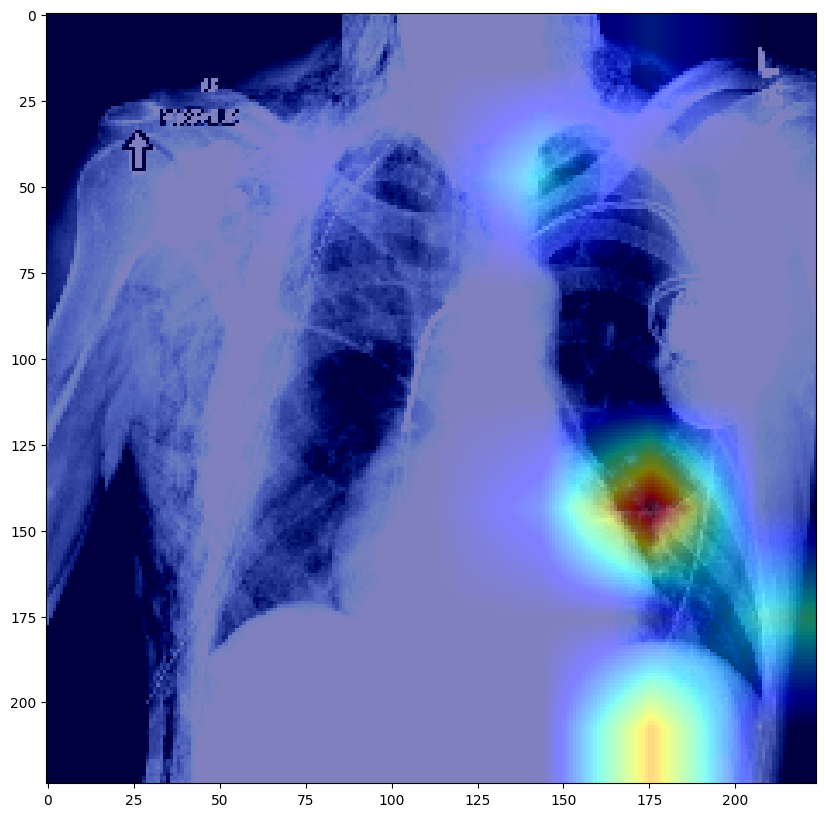

In [15]:
visualize_trainable_attention(attention_weights1, image1,label1)

torch.Size([1, 1, 224, 224])


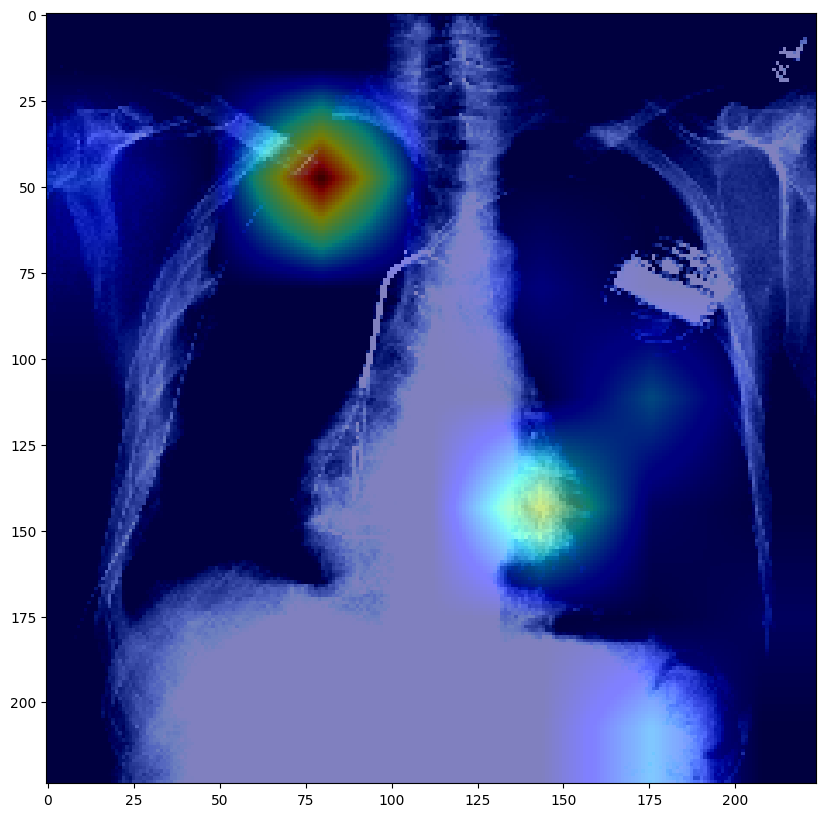

In [16]:
visualize_trainable_attention(attention_weights2, image2,label2)

The generated explanation can highlight potential parts of an input image atteded by the model for making a specific prediction.